In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [3]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

In [4]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [5]:
latent_dim = 100
img_size = 28 * 28  # For MNIST
batch_size = 64
learning_rate = 0.0002
num_epochs = 50

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 12235678.91it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 360909.59it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3416309.43it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [7]:
generator = Generator(input_dim=latent_dim, output_dim=img_size).to('cuda')
discriminator = Discriminator(input_dim=img_size).to('cuda')

criterion = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate)

In [8]:
for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(train_loader):
        
        # Adversarial ground truths
        valid = torch.ones((imgs.size(0), 1), requires_grad=False).to('cuda')
        fake = torch.zeros((imgs.size(0), 1), requires_grad=False).to('cuda')
        
        # Configure input
        real_imgs = imgs.view(imgs.size(0), -1).to('cuda')
        
        # ---------------------
        #  Train Generator
        # ---------------------
        optimizer_G.zero_grad()
        
        # Sample noise as generator input
        z = torch.randn((imgs.size(0), latent_dim)).to('cuda')
        
        # Generate a batch of images
        gen_imgs = generator(z)
        
        # Loss measures generator's ability to fool the discriminator
        g_loss = criterion(discriminator(gen_imgs), valid)
        
        g_loss.backward()
        optimizer_G.step()
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        
        # Measure discriminator's ability to classify real from generated samples
        real_loss = criterion(discriminator(real_imgs), valid)
        fake_loss = criterion(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        
        d_loss.backward()
        optimizer_D.step()
        
        # Print progress
        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {i}/{len(train_loader)} \
                  Loss D: {d_loss.item()}, loss G: {g_loss.item()}")


Epoch [0/50] Batch 0/938                   Loss D: 0.6794960498809814, loss G: 0.7095785140991211
Epoch [0/50] Batch 100/938                   Loss D: 0.15599244832992554, loss G: 1.3588876724243164
Epoch [0/50] Batch 200/938                   Loss D: 0.0468592643737793, loss G: 2.4269609451293945
Epoch [0/50] Batch 300/938                   Loss D: 0.5525897145271301, loss G: 0.9472665786743164
Epoch [0/50] Batch 400/938                   Loss D: 0.038327477872371674, loss G: 3.0458803176879883
Epoch [0/50] Batch 500/938                   Loss D: 0.48519328236579895, loss G: 1.3944231271743774
Epoch [0/50] Batch 600/938                   Loss D: 0.017091240733861923, loss G: 3.8164567947387695
Epoch [0/50] Batch 700/938                   Loss D: 0.19354167580604553, loss G: 1.8334531784057617
Epoch [0/50] Batch 800/938                   Loss D: 0.014087299816310406, loss G: 4.542208194732666
Epoch [0/50] Batch 900/938                   Loss D: 0.805201530456543, loss G: 2.966100215911

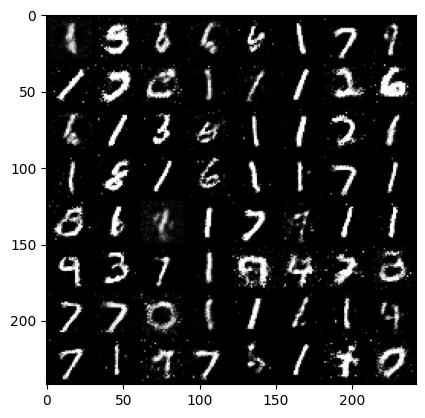

In [9]:
import matplotlib.pyplot as plt

z = torch.randn(64, latent_dim).to('cuda')
gen_imgs = generator(z).view(-1, 1, 28, 28).cpu().data

# Display the generated images
grid = torchvision.utils.make_grid(gen_imgs, nrow=8, normalize=True)
plt.imshow(grid.permute(1, 2, 0))
plt.show()


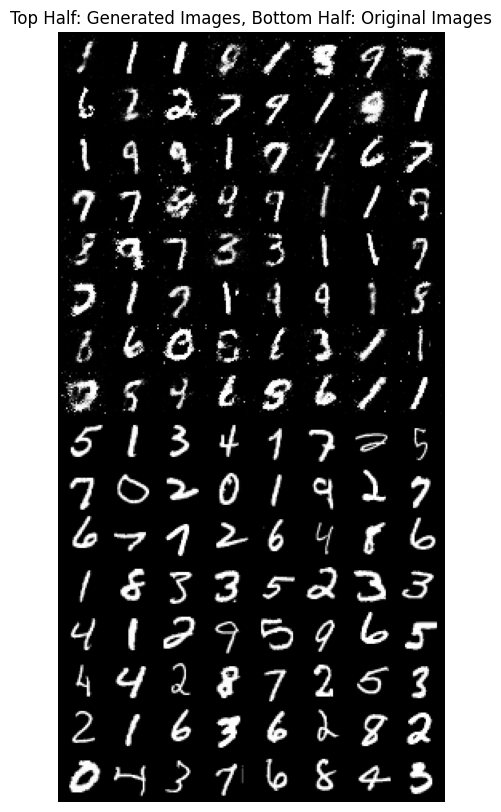

In [10]:
# Visualizing Generated and Original Images
def show_images(gen_images, real_images):
    gen_images = gen_images.view(gen_images.size(0), 1, 28, 28).cpu().data
    real_images = real_images.view(real_images.size(0), 1, 28, 28).cpu().data
    
    # Concatenate generated and real images
    images = torch.cat([gen_images, real_images])
    
    grid = torchvision.utils.make_grid(images, nrow=8, normalize=True)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title('Top Half: Generated Images, Bottom Half: Original Images')
    plt.axis('off')
    plt.show()

# Generate images
z = torch.randn(64, latent_dim).to('cuda')
gen_imgs = generator(z)

# Get a batch of real images
real_imgs, _ = next(iter(train_loader))
real_imgs = real_imgs[:64].view(64, -1).to('cuda')

# Show generated vs original images
show_images(gen_imgs, real_imgs)